<a id="0"></a> <br>
 # Table of Contents 
1. [Methodology](#1)
1. [Importing Libraries](#2)      
1. [Reading Data](#3)
    1. [Check for Null Values](#4) 
1. [Split Dataframe](#5)     
    1. [X](#6) 
    1. [y](#7)
1. [Encoding Categorical Values](#9)     
1. [Split Data into Train/Test](#10)
    1. [EC1](#11)
    1. [EC2](#12)
1. [Model Creation](#13)       
    1. [Setting Up Model](#14)      
    1. [Fitting Model](#15)     
1. [KFold Accuracy](#16)         
1. [Feature Importance](#17)             
1. [Applying Model to test.csv](#18)
    1. [Predicting Outcome](#19)

# <a id="1"></a> 
# Methodology
[TOC](#0)

This was an interesting and challenging dataset to work with. In this attempt, I decided not to use `greeks.csv` file at all and I am not quite sure how it would affect the overall performance. My approach was to get to the predictions with the least complicated or more straight forward dataset so I only used `train.csv`. In this notebook, I utilized XGBOOST as my go-to ML library.

- **Version 1:** There was no use of `scale_pos_weight`.
- *Many Versions Later*
- **Version 10:** Performed multiple GridSearch with different `scale_pos_weight` values.
- **Version 11:** Lost in the Matrix and started trying different `scale_pos_weight` and decided to fill NaN values with the mean of those columns.

# <a id="2"></a> 
# 1. Importing Libraries
[TOC](#0)

In [1]:
import pandas as pd
import numpy as np
import re
import category_encoders as ce
from collections import Counter
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib
from matplotlib import pyplot
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# <a id="3"></a> 
# 2. Reading Data
[TOC](#0)

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


In [3]:
df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
df.head(2)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0


The Id column isn't necessary and we can drop it.

In [4]:
df.drop(['Id'], axis=1, inplace=True)

Let's find if there are any columns with categorical values.

In [5]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

We can now perform a quick analysis on this column.

In [6]:
def sum_categorical(column_names):
    for values in column_names:
        print("Summary for {0}".format(values))
        print(df[values].value_counts())
        print("--------------------------")

In [7]:
sum_categorical(categorical_columns)

Summary for EJ
B    395
A    222
Name: EJ, dtype: int64
--------------------------


So the column EJ has categorical values with two distinct categories A and B. Let's see if we have an imbalanced dataset.

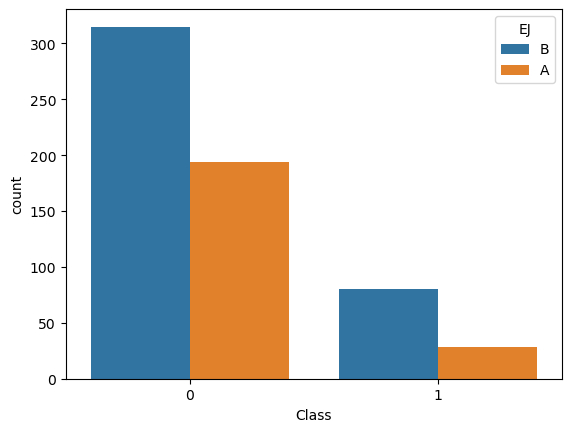

In [8]:
sns.countplot ( x = "Class", hue="EJ", data = df )
pyplot.show()

Yes, the quick visualization shows that we might have an imbalanced dataset.



# <a id="4"></a> 
# 2 - A. Check for Null Values
[TOC](#0)

In [9]:
df.isnull().values.any()

True

<div class="alert alert-block alert-danger"> 
<b>There are null values and we need to find what columns have null values ⚠️</b>
</div>
The following function went over each column and summarized if there were any null values as another way of checking.

In [10]:
column_names = list(df.columns.values)
def check_nan(column_names):
    for column in column_names:
        if df[column].isnull().sum() != 0:
            print("column: {0} --> {1}".format(column, df[column].isnull().sum()))
        
check_nan(column_names)

column: BQ --> 60
column: CB --> 2
column: CC --> 3
column: DU --> 1
column: EL --> 60
column: FC --> 1
column: FL --> 1
column: FS --> 2
column: GL --> 1


We can fill null values as follows and see how the model would perform.

In [11]:
def fill_nan(column_names):
    for column in column_names:
        if df[column].isnull().sum() != 0:
            mean = df[column].mean()
            df[column].fillna(mean, inplace = True)

In [12]:
fill_nan(column_names)

In [13]:
df.isnull().values.any()

False

# <a id="5"></a> 
# 3. Split Dataframe
[TOC](#0)

# <a id="6"></a> 
# 3 - A. X
[TOC](#0)

In [14]:
X = df.iloc[:, :-1]
X.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000


# <a id="7"></a> 
# 3. y
[TOC](#0)

In [15]:
y = df.iloc[:,-1]
y

0      1
1      0
2      0
3      0
4      1
      ..
612    0
613    0
614    0
615    0
616    0
Name: Class, Length: 617, dtype: int64

In [16]:
counter = Counter(y)
print(counter)

Counter({0: 509, 1: 108})


# <a id="8"></a> 
# 4. Encoding Categorical Values
[TOC](#0)

For this, I decided to use `OneHotEncoder` from `category_encoders` library.

In [17]:
enc = ce.OneHotEncoder(cols=["EJ"])
enc.fit(X)
encoded_x = enc.transform(X)
encoded_x.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000


# <a id="9"></a> 
# 5. Split Data into Train/Test
[TOC](#0)

In [18]:
seed = 0
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(encoded_x, y, test_size = test_size,
                                                    random_state = seed)
ec1_eval_set = [(X_train, y_train), (X_test, y_test)]

In [19]:
print("train y shape: {0} and test y shape: {1}".format(y_train.shape, y_test.shape))

train y shape: (493,) and test y shape: (124,)


In [20]:
positive_records = y_train.sum()
negative_records = len(y_train) - positive_records
estimate = negative_records / positive_records
print('y Estimate: %.3f' % estimate)

y Estimate: 4.478


The Counter method confirms that we have an imbalanced dataset. We can utilize estimating the value for the `scale_pos_weight` XGBoost hyperparameter (I ended up performing a lengthy grid search to find the right value).

# <a id="10"></a> 
# 6. Model Creation
[TOC](#0)

# <a id="11"></a> 
# 6 - A. Setting Up Model
[TOC](#0)

In [21]:
model = XGBClassifier(colsample_bylevel = 0.6, 
                      colsample_bytree = 1.0, 
                      learning_rate = 0.3, 
                      max_depth = 2, 
                      n_estimators = 100, 
                      subsample = 1.0,   
                      scale_pos_weight = 5)

# <a id="12"></a> 
# 6 - B. Fitting Model
[TOC](#0)

In [22]:
model.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = ["error", "logloss"],
          eval_set = ec1_eval_set, verbose = True)

[0]	validation_0-error:0.29412	validation_0-logloss:0.58808	validation_1-error:0.44355	validation_1-logloss:0.64736
[1]	validation_0-error:0.12373	validation_0-logloss:0.49848	validation_1-error:0.24194	validation_1-logloss:0.58199
[2]	validation_0-error:0.13185	validation_0-logloss:0.44767	validation_1-error:0.24194	validation_1-logloss:0.53391
[3]	validation_0-error:0.12576	validation_0-logloss:0.39804	validation_1-error:0.23387	validation_1-logloss:0.49501
[4]	validation_0-error:0.09736	validation_0-logloss:0.35618	validation_1-error:0.19355	validation_1-logloss:0.45094
[5]	validation_0-error:0.07708	validation_0-logloss:0.32159	validation_1-error:0.14516	validation_1-logloss:0.42632
[6]	validation_0-error:0.07099	validation_0-logloss:0.30280	validation_1-error:0.13710	validation_1-logloss:0.40379
[7]	validation_0-error:0.05882	validation_0-logloss:0.28120	validation_1-error:0.11290	validation_1-logloss:0.38709
[8]	validation_0-error:0.05477	validation_0-logloss:0.26229	validation_1

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

# <a id="13"></a> 
# 7. KFold Accuracy
[TOC](#0)

In [23]:
Kfold = KFold(n_splits = 10)
results_K = cross_val_score(model, encoded_x, y, cv = Kfold)
print("KFold - Accuracy: {0}% ({1})%)".format(results_K.mean()*100, results_K.std()*100))

KFold - Accuracy: 93.68588048651509% (2.6552857153256966)%)


With the new parameters, we got about 94% accuracy. Let's see how we do.

# <a id="14"></a> 
# 8. Feature Importance
[TOC](#0)

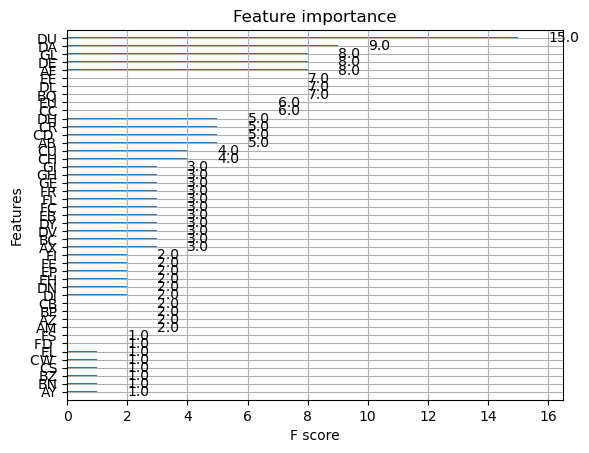

In [24]:
plot_importance(model)
pyplot.show()

<div class="alert alert-block alert-info"> <b>Feature Importance:</b> Maybe anything lower than 5.0 can be dropped. 🤔
</div>

# <a id="15"></a> 
# 9. Correlation

<div class="alert alert-block alert-warning">
<b>We can encode the whole dataframe without splitting into X and y</b>
</div>

In [25]:
df_enc = ce.OneHotEncoder(cols=["EJ"])
encoded_df = df_enc.fit_transform(df)
corr = encoded_df.corr()

<Axes: >

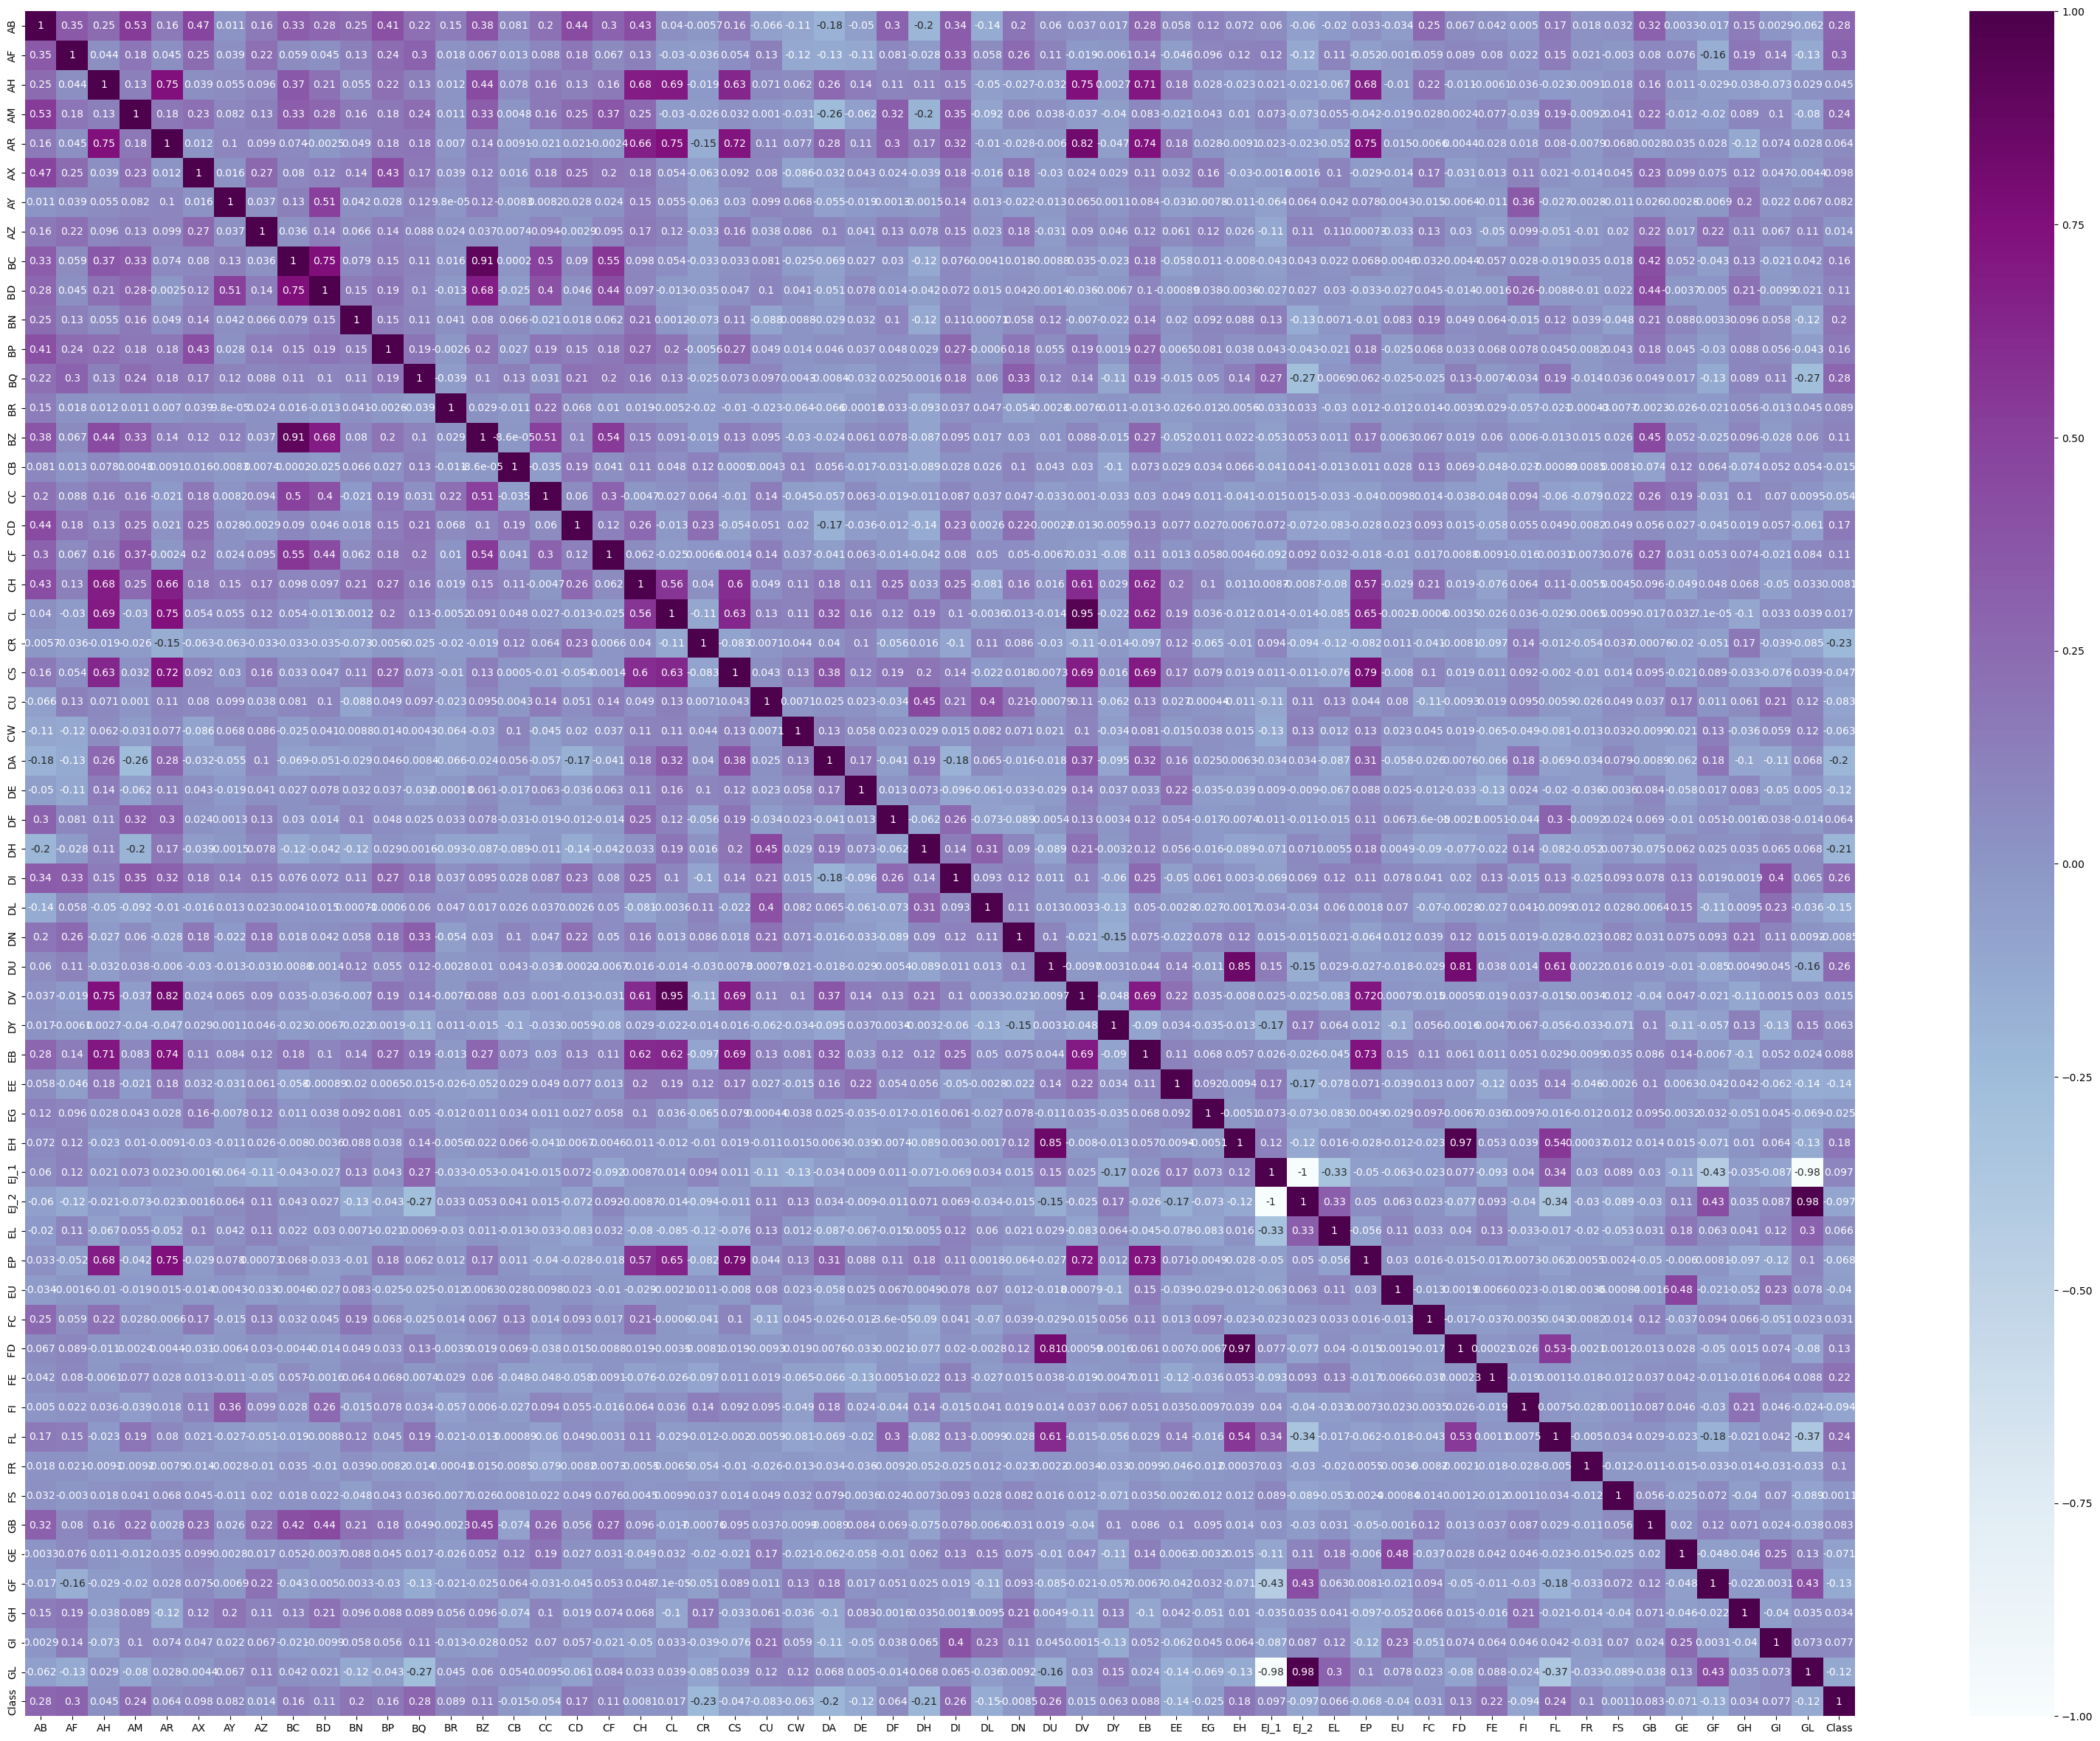

In [26]:
pyplot.figure(figsize=(40,30))
sns.heatmap(corr,annot=True,cmap='BuPu')

<div class="alert alert-block alert-info"> <b>Correlation:</b> At first glance, the feature importance and correlation graphs seem to be agreeing to certain point. 🤔
</div>

# <a id="16"></a> 
# 10. Applying Model to test.csv
[TOC](#0)

In [27]:
test_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")
test_df.head(2)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's check for null values.

In [28]:
test_df.isnull().values.any()

False

Great, no null vaues. We can also drop the Id column and save it to a different dataframe so that we can append our predictions back to the original `test.csv` dataframe.

In [29]:
new_test_df = test_df.drop(['Id'], axis = 1)
new_test_df.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's encode the EJ column as well.

In [30]:
encoded_test_df = enc.transform(new_test_df)
encoded_test_df.head(2)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# <a id="19"></a> 
# 11. Predicting Outcome
[TOC](#0)

Let's predict the class_0 first.

In [31]:
class_0_pred = model.predict_proba(encoded_test_df)[:,0]

And now, class_1.

In [32]:
class_1_pred = model.predict_proba(encoded_test_df)[:,1]

Let's append the predictions back to our `test.csv` dataframe.

In [33]:
test_df["class_0"] = pd.Series(class_0_pred).values
test_df["class_1"] = pd.Series(class_1_pred).values

Another dataframe with the columns we need.

In [34]:
submission_df = test_df[["Id", "class_0", "class_1"]]
submission_df

,Id,class_0,class_1
0,00eed32682bb,0.321698,0.678302
1,010ebe33f668,0.321698,0.678302
2,02fa521e1838,0.321698,0.678302
3,040e15f562a2,0.321698,0.678302
4,046e85c7cc7f,0.321698,0.678302


In [35]:
submission_df.to_csv("/kaggle/working/submission.csv", index=False)